# Bike Sharing Predictions

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8 #Set figure size

from scipy import stats
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,LassoCV, Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [79]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [80]:
hour = pd.read_csv('data/hour.csv')
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [81]:
hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [82]:
hour.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

No missing values

In [83]:
for column in hour.columns:
    print('{:<20}{:>20}'.format(column,len(hour[column].unique())))

instant                            17379
dteday                               731
season                                 4
yr                                     2
mnth                                  12
hr                                    24
holiday                                2
weekday                                7
workingday                             2
weathersit                             4
temp                                  50
atemp                                 65
hum                                   89
windspeed                             30
casual                               322
registered                           776
cnt                                  869


Instant has 17379 unique values (one for each row), so can be ignored for the model

## EDA

In [84]:
df = hour.drop(['instant','dteday'], axis=1)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


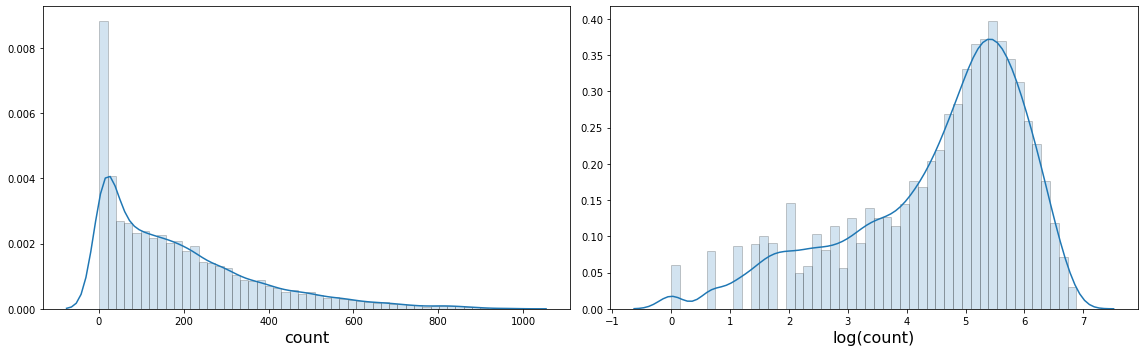

In [85]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(df['cnt'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(df['cnt']), ax=ax[1], hist_kws=hist_kws)
ax[0].set_xlabel('count', fontsize=16)
ax[1].set_xlabel('log(count)', fontsize=16)
plt.tight_layout()
plt.show()


Target vector is not normally distributed.

In [86]:
# Proof of non-normality: Shapiro Wilk Test

stat, p = stats.shapiro(np.log(df['cnt']))
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05

if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)


**Important Observation**

Even log transform of the target vector is not normally distributed. This may cause linear regression models to not work as well.

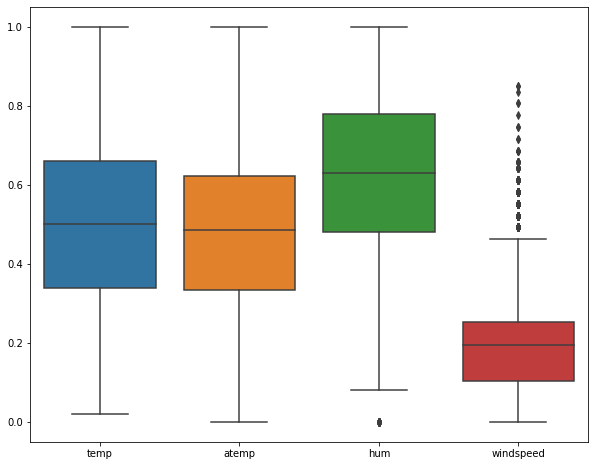

In [87]:
## Testing for Outliers- Using boxplots
#https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21

out_features = ['temp', 'atemp', 'hum', 'windspeed']


ax = sns.boxplot(data=df[out_features])


Observation:

Some outliers in humidity and many in windspeed.

Checking the maximum values:

In [88]:
#Windspeed
df.sort_values(by='windspeed', ascending= False).head(30)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
4315,3,0,7,17,0,0,0,3,0.80,0.7424,0.49,0.8507,181,177,358
4316,3,0,7,18,0,0,0,3,0.80,0.7424,0.49,0.8507,74,107,181
5635,3,0,8,17,0,6,0,3,0.64,0.5758,0.89,0.8358,2,14,16
9956,1,1,2,21,0,5,1,1,0.42,0.4242,0.35,0.8060,1,151,152
1259,1,0,2,15,0,5,1,1,0.46,0.4545,0.41,0.8060,5,50,55
1017,1,0,2,1,0,2,1,1,0.30,0.2424,0.42,0.7761,0,5,5
1261,1,0,2,17,0,5,1,1,0.32,0.2727,0.49,0.7463,8,181,189
1125,1,0,2,15,0,6,0,1,0.44,0.4394,0.16,0.7463,84,87,171
9653,1,1,2,4,0,0,0,2,0.10,0.0455,0.46,0.7164,0,1,1
11024,2,1,4,12,0,1,1,1,0.54,0.5152,0.28,0.7164,94,186,280


In [89]:
df[df['windspeed']>0.5].count()

season        230
yr            230
mnth          230
hr            230
holiday       230
weekday       230
workingday    230
weathersit    230
temp          230
atemp         230
hum           230
windspeed     230
casual        230
registered    230
cnt           230
dtype: int64

We see that the top two highest windspeeds occured in the same day, and around 230 rows have windspeeds seen as "outliers" by the boxplot. I think this is significant enough to keep in the data set.

In [90]:
# Humidity

df.sort_values(by='hum', ascending=True).head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1565,1,0,3,16,0,4,1,3,0.42,0.4242,0.0,0.2537,1,20,21
1570,1,0,3,21,0,4,1,3,0.36,0.3485,0.0,0.2239,1,27,28
1568,1,0,3,19,0,4,1,3,0.44,0.4394,0.0,0.5821,5,51,56
1567,1,0,3,18,0,4,1,3,0.44,0.4394,0.0,0.3582,2,80,82
1566,1,0,3,17,0,4,1,2,0.44,0.4394,0.0,0.3881,2,109,111
1564,1,0,3,15,0,4,1,3,0.44,0.4394,0.0,0.2239,3,11,14
1563,1,0,3,14,0,4,1,3,0.44,0.4394,0.0,0.2985,0,12,12
1562,1,0,3,13,0,4,1,3,0.42,0.4242,0.0,0.2239,1,11,12
1561,1,0,3,12,0,4,1,3,0.42,0.4242,0.0,0.2239,4,30,34
1571,1,0,3,22,0,4,1,2,0.34,0.3333,0.0,0.1343,4,30,34


0 Humidity seems odd, so checking how many records have 0 humidity

In [91]:
df[df['hum']==0.0].count()

season        22
yr            22
mnth          22
hr            22
holiday       22
weekday       22
workingday    22
weathersit    22
temp          22
atemp         22
hum           22
windspeed     22
casual        22
registered    22
cnt           22
dtype: int64

Since there are only 22 records with 0 humidity, we can delete them.

In [92]:
df = df[df['hum']>0.0]
df.sort_values(by='hum', ascending=True).head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1109,1,0,2,23,0,5,1,1,0.52,0.5000,0.08,0.2836,16,61,77
1108,1,0,2,22,0,5,1,1,0.54,0.5152,0.10,0.2537,19,88,107
1110,1,0,2,0,0,6,0,1,0.48,0.4697,0.12,0.4925,6,23,29
1112,1,0,2,2,0,6,0,1,0.44,0.4394,0.13,0.3881,3,14,17
1113,1,0,2,3,0,6,0,1,0.42,0.4242,0.14,0.2985,0,7,7
1111,1,0,2,1,0,6,0,1,0.46,0.4545,0.14,0.4179,10,21,31
1124,1,0,2,14,0,6,0,1,0.46,0.4545,0.15,0.6567,102,94,196
1115,1,0,2,5,0,6,0,1,0.40,0.4091,0.15,0.3284,0,3,3
1006,1,0,2,14,0,1,1,1,0.60,0.5909,0.15,0.4925,14,76,90
1114,1,0,2,4,0,6,0,1,0.40,0.4091,0.15,0.3284,0,3,3


<AxesSubplot:xlabel='season'>

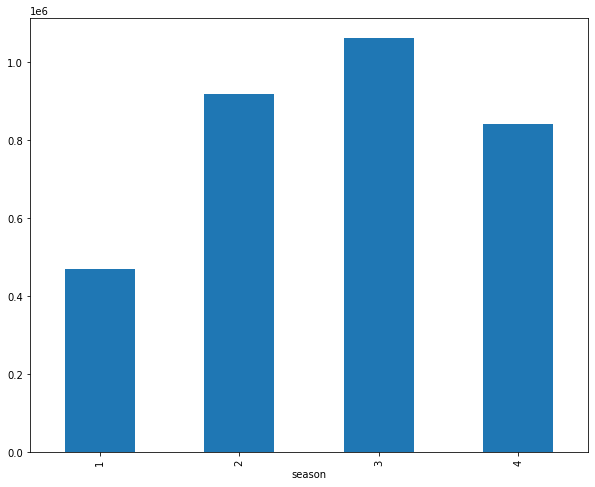

In [93]:
#Distribution of bikes with season
df.groupby(['season'])['cnt'].sum().plot(kind='bar')

Season 3 has the most amount of bike rentals.

<AxesSubplot:xlabel='mnth'>

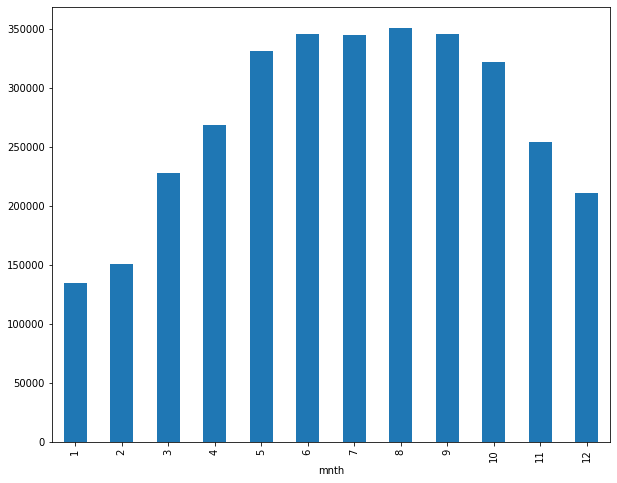

In [94]:
#Distribution of bikes with month
df.groupby(['mnth'])['cnt'].sum().plot(kind='bar')

Months 6-9 see the most bike rentals

<AxesSubplot:xlabel='hr'>

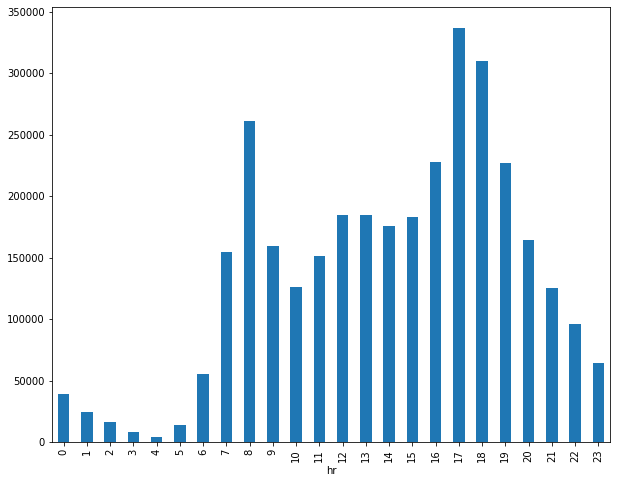

In [95]:
#Distribution of bikes with hour
df.groupby(['hr'])['cnt'].sum().plot(kind='bar')

Biggest spikes are around 8 am and 5 pm- usually work hours

<AxesSubplot:xlabel='weathersit'>

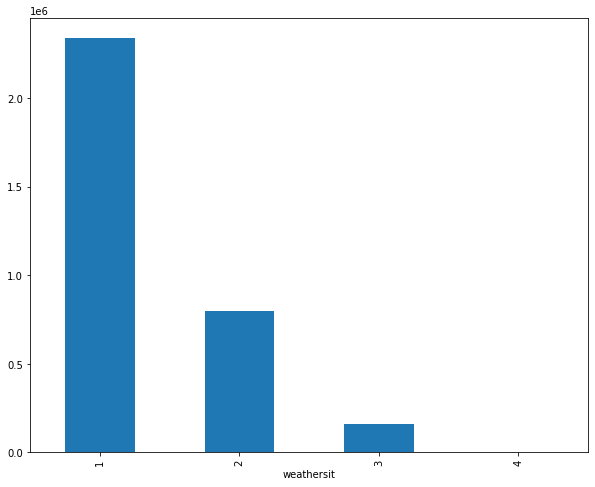

In [96]:
#Distribution of bikes with waether conditions
df.groupby(['weathersit'])['cnt'].sum().plot(kind='bar')

Most rentals with clear weather, almost no rentals during heavy rain/snow

In [97]:
#Affect of Holidays

df.groupby(['holiday'])['cnt'].sum()

holiday
0    3213621
1      78435
Name: cnt, dtype: int64

In [98]:
#Affect of working days

df.groupby(['workingday'])['cnt'].sum()

workingday
0    1000269
1    2291787
Name: cnt, dtype: int64

More rentals during workingdays (As supported by the spike in rentals at 8 am and 5 pm)

<AxesSubplot:>

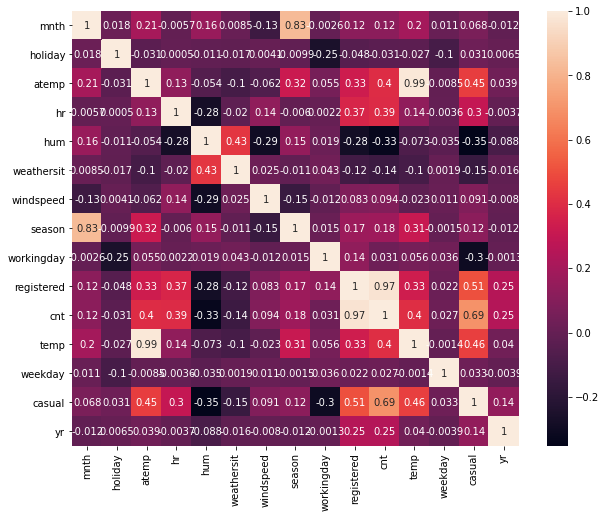

In [99]:
#Confusion Matrix of all features

plt.figure(figsize=(10, 8))
numerical = list(set(df.columns))
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix,annot=True)

cnt is more correlated with atemp, hr, casual, registered, temperature, and other weather conditions.

Since cnt consists of registered and casual, we should drop these features (there will certainly be a linear relation amongst them, so keeping them would mean that the performance of linear models will be incorrectly high)

## Modelling

In [100]:
#One Hot Encoding

features_to_encode = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [101]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [102]:
df = df.drop(['casual', 'registered'], axis=1)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [104]:
#Log transform cnt
Y = np.log(df.iloc[:,-1])
Y.head()

0    2.772589
1    3.688879
2    3.465736
3    2.564949
4    0.000000
Name: cnt, dtype: float64

In [105]:
# One - hot encode 'categorical' features and drop the original one.

df_train = one_hot(df, features_to_encode)
df_train = df_train.drop(features_to_encode, axis=1)
df_train.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.2879,0.81,0.0,16,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
1,0.22,0.2727,0.80,0.0,40,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,0.22,0.2727,0.80,0.0,32,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,0.24,0.2879,0.75,0.0,13,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,0.24,0.2879,0.75,0.0,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0


In [106]:
df_train.shape

(17357, 62)

In [107]:
X = df_train.drop(['cnt'], axis=1)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3, random_state=4)

In [108]:
# import some helper 

n_folds = 5
random_state = 4

def rmse_mae(model):
    
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    mae = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf))
    
    return rmse,mae

def beatiful_coef(coefs, feature_names=X.columns):
    return pd.DataFrame(coefs, index=feature_names,
                       columns=['coef']).sort_values('coef',
                                                  ascending=False)


def rmse(y_pred,y_true):
    result = np.sqrt(mean_squared_error(y_true,y_pred))
    
    return result

def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))

In [113]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,
random_state=random_state)    

# Cross validate model with Kfold stratified cross val

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=random_state))
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=random_state))
forest = RandomForestRegressor(random_state=random_state)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=0.05, max_depth=3, 
                         min_child_weight=1.7817, n_estimators=2200,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213,
                         random_state =7, nthread = -1)

In [114]:
warnings.filterwarnings('ignore')


score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(ridge)
score_forest_rmse,score_forest_mae = rmse_mae(forest)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
                                        
print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("Random Forest score RMSE: {:.4f} ({:.4f})\n".format(score_forest_rmse.mean(), score_forest_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score MAE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("Random Forest score MAE: {:.4f} ({:.4f})\n".format(score_forest_mae.mean(), score_forest_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))

Lasso score RMSE: 0.6225 (0.0130)

Ridge score RMSE: 0.6223 (0.0130)

Random Forest score RMSE: 0.3697 (0.0056)

Xgboost score RMSE: 0.3326 (0.0086)


Lasso score MAE: 0.6800 (0.0058)

Ridge score MAE: 0.6800 (0.0058)

Random Forest score MAE: 0.4947 (0.0039)

Xgboost score MAE: 0.4737 (0.0064)



In [115]:
regressions(lasso)

MAE : 0.469520
RMSE : 0.630174
R2 : 0.822239


In [116]:
regressions(ridge)

MAE : 0.469636
RMSE : 0.630125
R2 : 0.822267


In [117]:
regressions(forest)

MAE : 0.241185
RMSE : 0.369312
R2 : 0.938948


In [118]:
regressions(model_xgb)

MAE : 0.228399
RMSE : 0.341329
R2 : 0.947849


Random Forest and Gradient Boost outperform linear models

In [120]:
# Modeling step Test different algorithms 

kfold = 5

# Cross validate model with Kfold stratified cross val
regressors = []

regressors.append(DecisionTreeRegressor(random_state=random_state))
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state)))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(ExtraTreesRegressor(random_state=random_state))
regressors.append(GradientBoostingRegressor(random_state=random_state))
regressors.append(BaggingRegressor(random_state=random_state))
regressors.append(make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=random_state)))
regressors.append(make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=random_state)))
regressors.append(xgb.XGBRegressor(random_state=random_state))


In [121]:
%%time

cv_results = []
for regressor in regressors :
    print(regressor)
    cv_results.append(-cross_val_score(regressor, X_train, y = y_train, scoring = "neg_mean_absolute_error", cv = kfold,n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

DecisionTreeRegressor(random_state=4)
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=4))
RandomForestRegressor(random_state=4)
ExtraTreesRegressor(random_state=4)
GradientBoostingRegressor(random_state=4)
BaggingRegressor(random_state=4)
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0005, random_state=4))])
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridge', Ridge(alpha=0.0005, random_state=4))])
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=4, reg_alpha=None, reg_lambda=None,
             sca

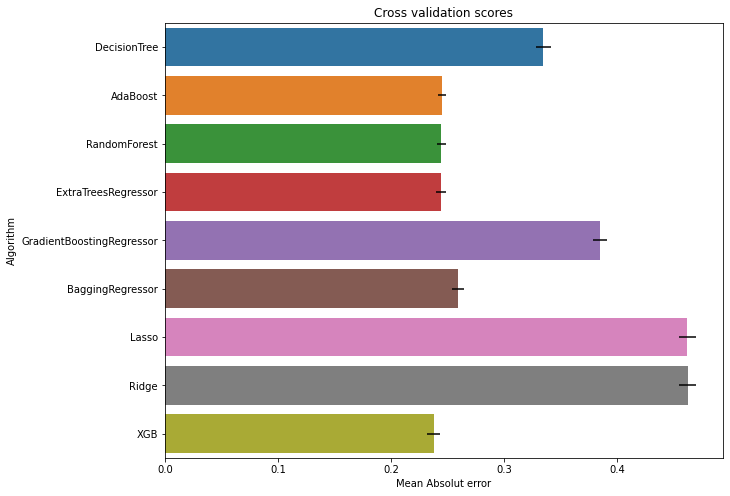

In [123]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTreesRegressor","GradientBoostingRegressor","BaggingRegressor","Lasso","Ridge",'XGB']})
plt.figure(figsize=(10, 8))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, **{'xerr':cv_std})
g.set_xlabel("Mean Absolut error")
g = g.set_title("Cross validation scores")

Best Score: XGB